In [594]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle as pkl
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, Draw

from rdkit.Chem.Descriptors import ExactMolWt, HeavyAtomMolWt # g/mol

from rdkit.Chem.Fragments import fr_Al_OH, fr_benzene

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline
import seaborn as sns; sns.set()
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

## MY OWN IMPORTED MODULES
from sklearn import preprocessing
from sklearn import utils
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from skopt import BayesSearchCV

import warnings
warnings.filterwarnings('ignore')

In [598]:
print((1,10))

(1, 10)


In [527]:
df = pd.read_excel('polymer_permeability_train.xlsx')

# Split name and strings into gas-specific datasets
He_data = df.loc[:,["Polymer", "SMILES", "He","Temp(C)"]]
H2_data = df.loc[:,["Polymer", "SMILES", "H2","Temp(C)"]]
CO2_data = df.loc[:,["Polymer", "SMILES", "CO2","Temp(C)"]]
O2_data = df.loc[:,["Polymer", "SMILES", "O2","Temp(C)"]]
N2_data = df.loc[:,["Polymer", "SMILES", "N2","Temp(C)"]]
CH4_data = df.loc[:,["Polymer", "SMILES", "CH4","Temp(C)"]]

def clean_df(df):
    df = df.dropna() #gets rid of NaN (not a number) entries in the dataframes
    df = df.reset_index(drop=True)

    # Drop duplicate SMILES rows (repeated entries from separate papers)
    df = df.drop_duplicates(subset = ["SMILES"])

    return df

He_data = clean_df(He_data)      # 309 SMILES, 2048 1s and 0s each SMILE , 308 if include T
H2_data = clean_df(H2_data)      # 329 324 
CO2_data = clean_df(CO2_data)    # 479 466
O2_data = clean_df(O2_data)      # 526 513
N2_data = clean_df(N2_data)      # 520 507
CH4_data = clean_df(CH4_data)    # 415 405
#print(len(He_data),len(H2_data),len(CO2_data),len(O2_data),len(N2_data),len(CH4_data))

# EVERY 'SMILES' WILL HAVE 2048 characters of 1 and 0
def calculate_fingerprint(mol):
    fps = []
    arr = np.zeros((1,))
    fp_temp = Chem.RDKFingerprint(mol, minSize=128)
    DataStructs.ConvertToNumpyArray(fp_temp, arr)
    fps.append(arr)
    return fps

def stacking_fp(data):
    # Start array with the 0th (first) molecule in the dataframe
    mol_init = Chem.MolFromSmiles(data.iloc[0,1])
    fp = calculate_fingerprint(mol_init)
    # will remain the first row of the entire fp array
    
    # Create database of fingerprints by stacking subsequent fingerprints
    for i in range(1, len(data)):
        try:
            mol_temp = Chem.MolFromSmiles(data.iloc[i,1])
            fp_temp = calculate_fingerprint(mol_temp)
        except:
            print("Error getting fingerprint")
        fp = np.vstack([fp, fp_temp])
    return fp

def molecular_weight(data):
    mol_init = Chem.MolFromSmiles(data.iloc[0,1])
    mw = ExactMolWt(mol_init)
        
    for i in range(1, len(data)):
        try:
            mol_temp = Chem.MolFromSmiles(data.iloc[i,1])
            mw_temp = ExactMolWt(mol_temp)
        except:
            print("Error getting molecular weight")
        mw = np.vstack([mw, mw_temp])
    return mw

# FINGERPRINT for All Data

In [528]:
dataHe = He_data.copy(deep=True)
dataH2 = H2_data.copy(deep=True)
dataCO2 = CO2_data.copy(deep=True)
dataO2 = O2_data.copy(deep=True)
dataN2 = N2_data.copy(deep=True)
dataCH4 = CH4_data.copy(deep=True)

# Still have the same size as previous, so all good
He_fp = stacking_fp(dataHe)  
H2_fp = stacking_fp(dataH2)
CO2_fp = stacking_fp(dataCO2)
O2_fp = stacking_fp(dataO2)
N2_fp = stacking_fp(dataN2)
CH4_fp = stacking_fp(dataCH4)

# Other Related Data

In [529]:
He_mw = molecular_weight(dataHe)
H2_mw = molecular_weight(dataH2)
CO2_mw = molecular_weight(dataCO2)
O2_mw = molecular_weight(dataO2)
N2_mw = molecular_weight(dataN2)
CH4_mw = molecular_weight(dataCH4)
mol_init = Chem.MolFromSmiles(dataN2.iloc[0,1])

# All permeability datas converted to 10^x
permHe = np.log10(dataHe['He'])      # R2 train: 0.958, R2 test: 0.693 these are for randomforestregressor method
permH2 = np.log10(dataH2['H2'])      # 0.960, 0.726
permCO2 = np.log10(dataCO2['CO2'])   # 0.952, 0.691
permO2 = np.log10(dataO2['O2'])      # 0.954, 0.701
permN2 = np.log10(dataN2['N2'])      # 0.958, 0.709
permCH4 = np.log10(dataCH4['CH4'])   # 0.973, 0.634

tempHe = np.array([dataHe["Temp(C)"]]).T
tempH2 = np.array([dataH2["Temp(C)"]]).T
tempCO2 = np.array([dataCO2["Temp(C)"]]).T
tempO2 = np.array([dataO2["Temp(C)"]]).T
tempN2 = np.array([dataN2["Temp(C)"]]).T
tempCH4 = np.array([dataCH4["Temp(C)"]]).T

# MODEL TRAINING STARTS HERE

# MODEL VALIDATION 
(Finding the appropriate fit of line)

Molecular weight, functional group, length, temperature

$\bf{Gradient\ Boosting\ Regression\ Hyperparamaeter\ Tuning}$

Hyperparameter tuning is the process of finding the optimal values for the hyperparameters of a machine learning model. Hyperparameters are parameters that are set before training the model and cannot be learned from the data, unlike model parameters that are learned during training. Examples of hyperparameters in machine learning models include learning rate, regularization strength, maximum depth of a tree, number of estimators, and so on.

Hyperparameter tuning is an important step in building an accurate and robust machine learning model, as the choice of hyperparameter values can significantly impact the model's performance. Choosing suboptimal hyperparameter values can result in a poorly performing model that may be overfitting or underfitting the data.

$\bf{There\ are\ various\ techniques\ for\ hyperparameter\ tuning,\ including:}$

$\bf{Grid\ Search}$: In grid search, all possible combinations of hyperparameter values are exhaustively searched over a predefined range of values. Grid search is simple to implement and can be used with any machine learning algorithm, but it can be computationally expensive when dealing with a large number of hyperparameters or a large search space.

In [ ]:
# Define the hyperparameter search space
param_grid = {'n_estimators': [100, 200, 300],
              'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [3, 4, 5],
              'min_samples_split': [2, 3, 4],
              'min_samples_leaf': [1, 2, 3]}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best hyperparameters
best_params = grid_search.best_params_

$\bf{Random\ Search}$: In random search, random combinations of hyperparameter values are sampled from a predefined distribution or range. Random search is less computationally expensive than grid search, as it doesn't exhaustively search all possible combinations, but it may require more iterations to find the optimal hyperparameter values.


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Specify the hyperparameter distributions
param_dist = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    # Add more hyperparameters to be tuned
}

#param_dist = {
#    'n_estimators': randint(50, 200),
#    'max_depth': randint(1, 6),
#    'learning_rate': uniform(0.01, 0.2)
#}

# Instantiate the GradientBoostingRegressor model
gbm = GradientBoostingRegressor()

# Perform random search
random_search = RandomizedSearchCV(gbm, param_distributions=param_dist, cv=5)
#random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, scoring='r2')

random_search.fit(X_train, y_train)

# Best hyperparameters found
best_params = random_search.best_params_

$\bf{Bayesian\ Optimization}$: Bayesian optimization is a probabilistic model-based optimization technique that models the unknown function (e.g., the model's performance) using a probabilistic surrogate model, and uses an acquisition function to decide which hyperparameter values to sample next based on the surrogate model. Bayesian optimization is more efficient than grid search and random search in terms of the number of iterations required to find the optimal hyperparameter values.



In [ ]:
from skopt import BayesSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Specify the hyperparameter search space
param_dist = {
    'n_estimators': (50, 200),
    'learning_rate': (0.01, 0.2),
    'max_depth': (3, 5),
    # Add more hyperparameters to be tuned
}

#param_space = {
#    'n_estimators': (50, 200),
#    'max_depth': (1, 6),
#    'learning_rate': (0.01, 0.2, 'log-uniform')
#}


# Instantiate the GradientBoostingRegressor model
gbm = GradientBoostingRegressor()

# Perform Bayesian optimization
bayes_search = BayesSearchCV(gbm, param_dist, n_iter=50, cv=5)

bayes_search.fit(X_train, y_train)

# Best hyperparameters found
best_params = bayes_search.best_params_


$\bf{Genetic\ Algorithms}$: Genetic algorithms are search algorithms inspired by the process of natural selection. In the context of hyperparameter tuning, genetic algorithms use the principles of crossover, mutation, and selection to evolve a population of hyperparameter values over multiple generations to find the optimal hyperparameter values.



In [ ]:
from sklearn.model_selection import KFold
from geneticalgorithm import geneticalgorithm as ga
from sklearn.ensemble import GradientBoostingRegressor

# Define the objective function to be optimized
def objective_function(params):
    # Convert hyperparameter values to int or float as needed
    n_estimators = int(params[0])
    max_depth = int(params[1])
    learning_rate = params[2]
    
    # Instantiate the model with the hyperparameter values
    model = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
    
    # Perform cross-validation and calculate R^2 score
    cv = KFold(n_splits=5)
    scores = []
    for train_index, val_index in cv.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        model.fit(X_train_fold, y_train_fold)
        y_pred_val = model.predict(X_val_fold)
        score = r2_score(y_val_fold, y_pred_val)
        scores.append(score)
    mean_score = np.mean(scores)
    
    return -mean_score  # Negative mean R^2 score as we want to maximize it

# Define the hyperparameter bounds for optimization
varbound = np.array([[50, 200], [1, 6], [0.01, 0.2]])

# Instantiate the genetic algorithm optimizer
optimizer = ga(function=objective_function, dimension=3, variable_type='real', variable_boundaries=varbound)

# Run the optimization
optimizer.run()

# Get the best hyperparameter values
best_params = optimizer.output_dict['variable']
n_estimators = int(best_params[0])
max_depth = int(best_params[1])
learning_rate = best_params[2]

# Instantiate the model with the best hyperparameter values
best_model = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
best_model.fit(X_train, y_train)

# Evaluate the best model on the test data
y_pred_test = best_model.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)

In this example, the geneticalgorithm library is used for optimization. The objective_function represents the fitness function to be optimized, which calculates the cross-validated R^2 score for a given set of hyperparameter values. The varbound variable specifies the bounds for each hyperparameter to search within. The optimizer then runs the genetic algorithm to find the best hyperparameter values that maximize the cross-validated R^2 score. Finally, the best model with the best hyperparameter values is trained on the entire training data and evaluated on the test data using the R^2 score.

$\bf{Cross-validation}$: Cross-validation is a technique used to estimate the performance of a model by partitioning the data into multiple folds and training the model on different folds while using the remaining folds for validation. Cross-validation can be used in combination with other hyperparameter tuning techniques to obtain a more reliable estimate of the model's performance and the optimal hyperparameter values.

Once the hyperparameter tuning technique is chosen, it is typically implemented using a combination of loops, functions, and/or libraries in the programming language being used (e.g., Python, R, etc.). The hyperparameter values that result in the best performance on the validation set (or during cross-validation) are then selected as the optimal hyperparameter values for the model. It's important to note that hyperparameter tuning should be done on a separate validation set or using cross-validation to avoid overfitting the hyperparameters to the training data.

# SPLIT DATA INTO TRAINING AND TESTING SET

In [607]:
fingerprint_data = He_fp
perm_data = permHe

X_train, X_test, y_train, y_test = train_test_split(fingerprint_data, perm_data, train_size=0.8, random_state=0)

# Technique A: Random Forest Regressor

Training R^2: 0.9629
Testing R^2: 0.6806
Mean Absolute Error: 0.4313
Mean Squared Error: 0.3498
Root Mean Squared Error: 0.5914


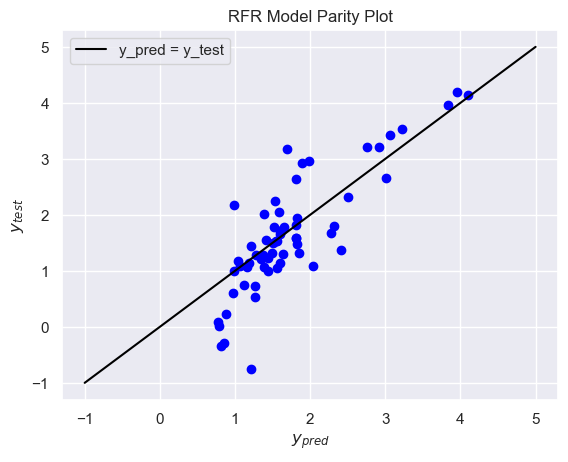

In [608]:
rfr = RandomForestRegressor(random_state=0)
rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test) # use testing data to find y values from regression values

plt.scatter(y_pred, y_test, color='blue')
plt.plot([-1, 5], [-1, 5], color='black', label='y_pred = y_test')
plt.xlabel('$y_{pred}$')
plt.ylabel('$y_{test}$')
plt.legend()
plt.title('RFR Model Parity Plot');

print('Training R^2: %.4f' %rfr.score(X_train, y_train))
print('Testing R^2: %.4f' % rfr.score(X_test, y_test))
print('Mean Absolute Error: %.4f' %mean_absolute_error(y_test, y_pred))
print('Mean Squared Error: %.4f' %mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error: %.4f' %np.sqrt(mean_squared_error(y_test, y_pred)));


# Technique B: Gradient Boosting

In both examples, X_train and X_test represent the training and testing data, respectively, and y_train represents the target labels for the training data. The n_estimators parameter specifies the number of weak models to be combined, and the learning_rate parameter controls the contribution of each weak model to the final prediction. Other hyperparameters can also be tuned to optimize the performance of the ensemble model.

Finding the hyperparameter for Gradient Boosting

In [606]:
# Specify the hyperparameter search space
# param_space = {'n_estimators': (50, 200),'learning_rate': (0.01, 0.2),'max_depth': (3, 5)}
    # Add more hyperparameters to be tuned

param_space = {'n_estimators': (50, 200),'max_depth': (1, 6)}#,'learning_rate': (0.01, 0.2, 'log-uniform')}

# Instantiate the GradientBoostingRegressor model
gbm = GradientBoostingRegressor()

# Perform Bayesian optimization
bayes_search = BayesSearchCV(gbm, param_space, n_iter=50, cv=5)

bayes_search.fit(X_train, y_train)

# Best hyperparameters found
best_params = bayes_search.best_params_
print(best_params)

KeyboardInterrupt: 

Training R^2: 0.9717
Testing R^2: 0.6521
Mean Absolute Error: 0.4475
Mean Squared Error: 0.3811
Root Mean Squared Error: 0.6173


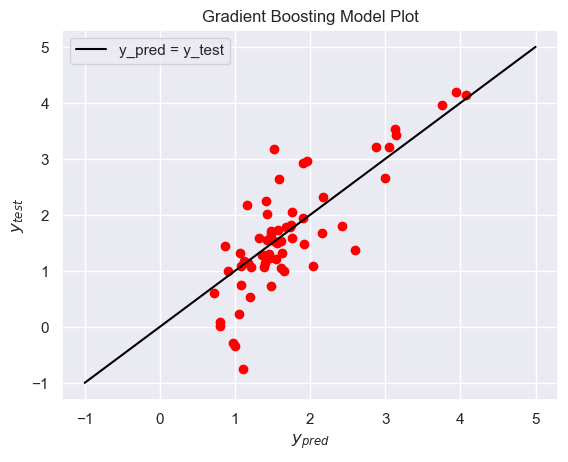

In [609]:
# Instantiate the GradientBoostingRegressor model
gbm = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=0)

# Fit the model to the training data
gbm.fit(X_train, y_train)

# Make predictions on new data
y_pred = gbm.predict(X_test)

plt.scatter(y_pred, y_test, color='red')
plt.plot([-1, 5], [-1, 5], color='black', label='y_pred = y_test')
plt.xlabel('$y_{pred}$')
plt.ylabel('$y_{test}$')
plt.legend()
plt.title('Gradient Boosting Model Plot');

print('Training R^2: %.4f' %gbm.score(X_train, y_train))
print('Testing R^2: %.4f' % gbm.score(X_test, y_test))
print('Mean Absolute Error: %.4f' %mean_absolute_error(y_test, y_pred))
print('Mean Squared Error: %.4f' %mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error: %.4f' %np.sqrt(mean_squared_error(y_test, y_pred)));


# Technique C: Adaboost

Training R^2: 0.8256
Testing R^2: 0.6107
Mean Absolute Error: 0.5022
Mean Squared Error: 0.4264
Root Mean Squared Error: 0.6530


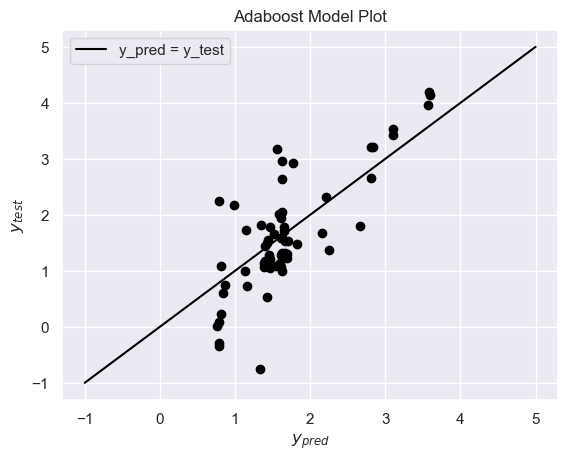

In [610]:
# Instantiate the AdaBoostRegressor model
ada = AdaBoostRegressor(n_estimators=100, learning_rate=0.1, random_state=0)

# Fit the model to the training data
ada.fit(X_train, y_train)

# Make predictions on new data
y_pred = ada.predict(X_test)

print('Training R^2: %.4f' %ada.score(X_train, y_train))
print('Testing R^2: %.4f' % ada.score(X_test, y_test))
print('Mean Absolute Error: %.4f' %mean_absolute_error(y_test, y_pred))
print('Mean Squared Error: %.4f' %mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error: %.4f' %np.sqrt(mean_squared_error(y_test, y_pred)));

plt.scatter(y_pred, y_test, color='black')
plt.plot([-1, 5], [-1, 5], color='black', label='y_pred = y_test')
plt.xlabel('$y_{pred}$')
plt.ylabel('$y_{test}$')
plt.legend()
plt.title('Adaboost Model Plot');

# Technique D: XGBoost

Training R^2: 0.9972
Testing R^2: 0.6722
Mean Absolute Error: 0.4198
Mean Squared Error: 0.3590
Root Mean Squared Error: 0.5992


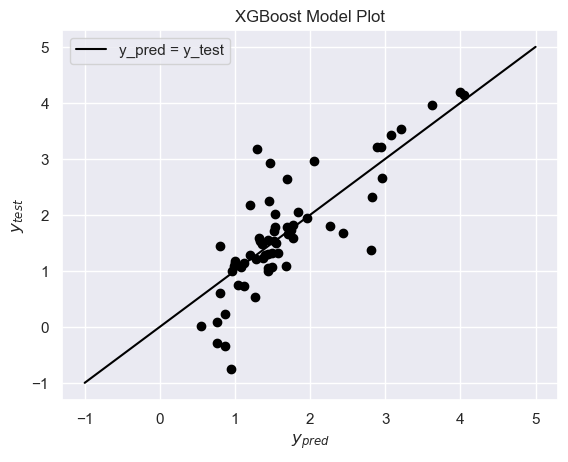

In [611]:
# Define the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)#, max_depth=5)

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = xgb_model.predict(X_test)

# Evaluate the model using the Mean Squared Error metric
y_train_pred = xgb_model.predict(X_train)

print('Training R^2: %.4f' %r2_score(y_train,y_train_pred))
print('Testing R^2: %.4f' %r2_score(y_test,y_pred))
#print('Training R^2: %.4f' %r2_score(X_train, y_train))
#print('Testing R^2: %.4f' % xgb.score(X_test, y_test))
print('Mean Absolute Error: %.4f' %mean_absolute_error(y_test, y_pred))
print('Mean Squared Error: %.4f' %mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error: %.4f' %np.sqrt(mean_squared_error(y_test, y_pred)));

plt.scatter(y_pred, y_test, color='black')
plt.plot([-1, 5], [-1, 5], color='black', label='y_pred = y_test')
plt.xlabel('$y_{pred}$')
plt.ylabel('$y_{test}$')
plt.legend()
plt.title('XGBoost Model Plot');

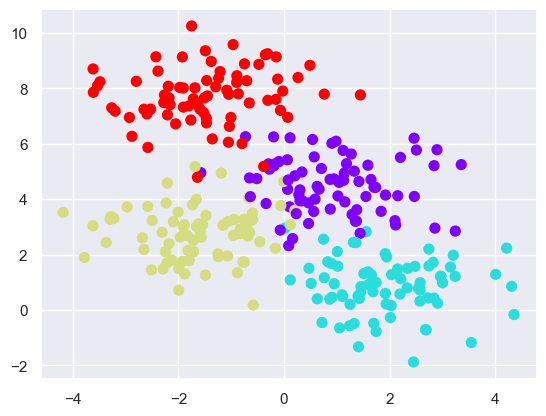

In [138]:
X, y = make_blobs(n_samples=300, centers=4,n_features = 2,
                  random_state=0, cluster_std=1.0)
# n_samples - num of points in total
# centers - number of clusters (different lumps of points)
# by default - X will have two columns
# data plotted are just the x values
# the y refers to different set of identity (basically plotting x and y, 
# and each data point has other meanings - here indicated with colors)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');
# c is to set the color (here will vary since y has diff values
# s is to set the size of the scatters - here is fixed to 50
#print(y)#.shape)

tree = DecisionTreeClassifier().fit(X, y)

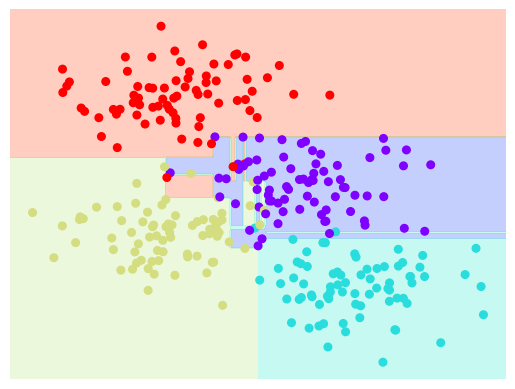

In [141]:
## GENERAL APPROACH TO DO DECISION TREES
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3) #zorder is just the order of plotting, doesn;tt matter here
    ax.axis('tight') # if we have subplots, the axes won't overlap with each other
    ax.axis('off') # turn off axis
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    
visualize_classifier(DecisionTreeClassifier(), X, y)

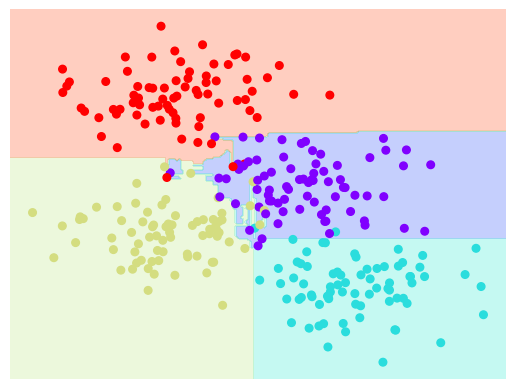

In [142]:
## TO AVOID OVERFITTING, USE BAGGING TO DO DECISION TREES
tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

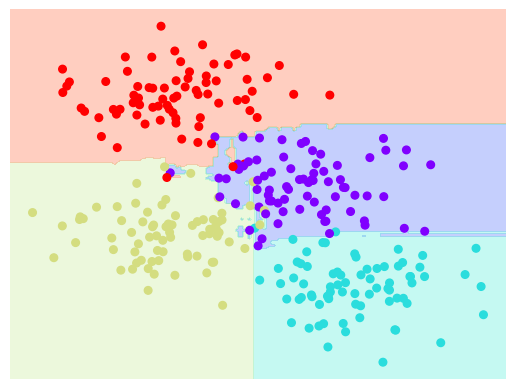

In [146]:
## MORE RANDOMIZED DECISIONT REES, FOLLOWED UP FROM ABOVE
model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);